# Chicago Beach Data in Python

## A data science practice

Chicago has 27 public beaches, along 26 miles of the city's lakefront shoreline, managed by the Chicago Park District.
<br> Here are the beach locations:
![Chicago Beach Locations](https://github.com/agnesbao/chicagobeach/blob/master/Ecoli_test_locations.png?raw=true)

The City of Chicago provides the public with beach water quality data and weather data hour by hour from several sensors during the summer. 

The water quality data is available at https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku. 

The weather data is available at https://data.cityofchicago.org/Parks-Recreation/Beach-Weather-Stations-Automated-Sensors/k7hf-8y75.

Here are the locations of the water and weather sensors:
![](https://github.com/agnesbao/chicagobeach/blob/master/sensor_locations.png?raw=true)

Let's take a look at the beach water data first.
Using the website's API, we can grab all data points:

In [1]:
# import packages
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [2]:
# fetch data from API
def request_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
    return pd.DataFrame(data)

water_url = "https://data.cityofchicago.org/resource/46rk-hgnz.json?$limit=50000"
water_df = request_data(water_url)
water_df = water_df.dropna(subset=['measurement_timestamp'])
water_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34917 entries, 0 to 34922
Data columns (total 10 columns):
battery_life                   34917 non-null object
beach_name                     34917 non-null object
measurement_id                 34917 non-null object
measurement_timestamp          34917 non-null object
measurement_timestamp_label    34917 non-null object
transducer_depth               10034 non-null object
turbidity                      34917 non-null object
water_temperature              34917 non-null object
wave_height                    34690 non-null object
wave_period                    34690 non-null object
dtypes: object(10)
memory usage: 2.9+ MB


The water sensor measures: 'turbidity', which is the key measurement of water quality, higher number means the water is more cloudy. In addition, there is 'water_temperature, 'wave_height' and 'wave_period'.
<br> The data starts from May 2014. 
<br> Let's look at which sensors are giving out readings each year.

In [3]:
water_df.index = pd.DatetimeIndex(water_df.measurement_timestamp)
water_df = water_df.sort_index()
for yr in water_df.index.year.unique():
    print(str(yr)+': ')
    print(water_df.beach_name[water_df.index.year==yr].unique())

2013: 
['Montrose Beach' 'Osterman Beach' 'Ohio Street Beach' 'Calumet Beach'
 '63rd Street Beach']
2014: 
['Rainbow Beach' 'Calumet Beach' 'Montrose Beach' 'Ohio Street Beach'
 '63rd Street Beach' 'Osterman Beach']
2015: 
['Rainbow Beach' 'Ohio Street Beach' '63rd Street Beach' 'Calumet Beach'
 'Montrose Beach' 'Osterman Beach']
2016: 
['Ohio Street Beach' 'Montrose Beach' 'Calumet Beach']
2017: 
['Ohio Street Beach']


Oh no, looks like the sensors are dying off. Only the one at Ohio Street Beach is still alive this year.

How about the weather data?

In [4]:
weather_url = 'https://data.cityofchicago.org/resource/77jv-5zb8.json?$limit=60000'
weather_df = request_data(weather_url)
weather_df = weather_df.dropna(subset=['measurement_timestamp'])
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56760 entries, 0 to 56762
Data columns (total 18 columns):
air_temperature                56685 non-null object
barometric_pressure            56614 non-null object
battery_life                   56760 non-null object
heading                        37287 non-null object
humidity                       56760 non-null object
interval_rain                  56760 non-null object
maximum_wind_speed             56760 non-null object
measurement_id                 56760 non-null object
measurement_timestamp          56760 non-null object
measurement_timestamp_label    56760 non-null object
precipitation_type             37287 non-null object
rain_intensity                 37287 non-null object
solar_radiation                56760 non-null object
station_name                   56760 non-null object
total_rain                     37287 non-null object
wet_bulb_temperature           37287 non-null object
wind_direction                 56760 non-nu

Are all weather sensors giving readings?

In [5]:
weather_df.index=pd.DatetimeIndex(weather_df.measurement_timestamp)
weather_df = weather_df.sort_index()
for yr in weather_df.index.year.unique():
    print(str(yr)+': ')
    print(weather_df.station_name[weather_df.index.year==yr].unique())

2015: 
['63rd Street Weather Station' 'Oak Street Weather Station'
 'Foster Weather Station']
2016: 
['63rd Street Weather Station' 'Foster Weather Station'
 'Oak Street Weather Station']
2017: 
['63rd Street Weather Station' 'Oak Street Weather Station'
 'Foster Weather Station']


In order to monitor swimming safety, the city also tests for E.coli from all 27 beach locations. The E.coli lab data is available here: https://data.cityofchicago.org/Parks-Recreation/Beach-Lab-Data/2ivx-z93u
<br>Let's get the lab data.

In [6]:
lab_url = "https://data.cityofchicago.org/resource/awhh-mb2r.json?$limit=50000"
lab_df = request_data(lab_url)
# some dates show the year as 0016, which should be 2016
def fix_date(date_str):
    if type(date_str)==str:
        return date_str.replace('0016','2016')
lab_df.culture_sample_1_timestamp = lab_df.culture_sample_1_timestamp.apply(fix_date)
lab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20264 entries, 0 to 20263
Data columns (total 16 columns):
beach                         20264 non-null object
culture_reading_mean          17964 non-null object
culture_sample_1_reading      17906 non-null object
culture_sample_1_timestamp    18003 non-null object
culture_sample_2_reading      17854 non-null object
culture_sample_2_timestamp    1516 non-null object
culture_sample_interval       1516 non-null object
culture_test_id               18003 non-null object
dna_reading_mean              2936 non-null object
dna_sample_1_reading          2936 non-null object
dna_sample_2_reading          2912 non-null object
dna_sample_timestamp          2936 non-null object
dna_test_id                   2936 non-null object
latitude                      17219 non-null object
location                      17219 non-null object
longitude                     17219 non-null object
dtypes: object(16)
memory usage: 2.5+ MB


This dataset contains readings from two E.coli testing techniques. From 2006-2016 they were using culture based testing, a slower technique which takes 18-24hrs.  Since 2015 they gradually switched to DNA testing, which only takes a few hours, but is also more expensive. All beaches had culture reading untill 2016. In 2017 the tests switched completely to DNA testing. 
<br> In the data set there are 675 samples that were tested by both techniques. We can use those data to see whether the two techniques are consistent with each other.

correlation: r=0.649365661046; p=4.41649895911e-82


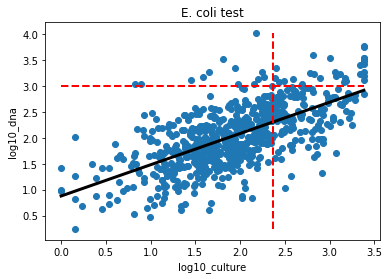

In [7]:
# dataset with both culture and dna
culture_dna = lab_df.dropna(subset=['dna_reading_mean','culture_reading_mean'])
culture_reading = np.log10(culture_dna.culture_reading_mean.astype(float))
dna_reading = np.log10(culture_dna.dna_reading_mean.astype(float))
# threshold for red flag 
culture_thresh = np.log10(235)
dna_thresh = np.log10(1000)
# calculate the correlation between culture test and dna test
(r,p) = pearsonr(culture_reading, dna_reading)
print('correlation: r='+str(r)+'; p='+str(p))
# plotting the relationship between the two testings
X = culture_reading.values.reshape(-1,1)
y = dna_reading.values.reshape(-1,1)
regr = LinearRegression()
regr.fit(X,y)
fit_space = np.linspace(min(X), max(X),2).reshape(-1,1)
y_fit = regr.predict(fit_space)
plt.scatter(X,y)
plt.plot(fit_space, y_fit,'k',linewidth=3)
plt.plot(fit_space,[dna_thresh, dna_thresh],'r--',linewidth=2)
plt.plot([culture_thresh, culture_thresh],[min(y),max(y)],'r--',linewidth=2)
plt.xlabel('log10_culture')
plt.ylabel('log10_dna')
plt.title('E. coli test')
plt.show()

What does this plot tell us?

First of all, the culture testing and dna testing techniques are positivily correlated with each other, following the fitted black line.

Second, the culture testing gives more alarms than dna testing: the vertical dashed line is the threshold for culture testing readings: left to the line means the water is safe, right to the line means a swim advisory should be issued. Similarly, the horizontal line is the threshold for dna testing: below the line is save and above the line is unsafe. Therefore, bottom-left are safe results according to both tests, upper-right are unsafe results flagged by both, and upper-left are unsafe according to dna but missed by culture testing, and bottom-right are unsafe according to culture testing but not dna.

In summary, using different testing techniques on the same water sample, DNA method will give 6.5% of the samples a red flag, whereas culture method alarm 23.4% of the samples. 

## Predicting swim advisories 

In the following section, I'll use historical available data to predict swim advisories at one beach. The Chi Hack Night has done an awesome project a comprehensive task last year. Check out: https://chihacknight.org/blog/2017/09/13/clear-water.html

For my own practice, here I will use water and weather data since 2015, to predict whether a swim advisory will be issued at the Montrose beach in 2017 from day to day (a classification problem). The prediction performance will be measured by how accurate the red flags are issued according to the lab data in 2017. 

First, prepare the data set. Basically, I log-transform any feature that's severely right-skewed. I summarize hourly water and weather by calculating the mean and variance by day. Finally, I included columns that marks the weekday of the date.  

In [8]:
# target data y: Montrose beach, red flag: 1, safe: 0
y = lab_df[(lab_df.beach=='Montrose')]
y = y.dropna(subset=['dna_sample_timestamp'])
y.index = pd.DatetimeIndex(y.dna_sample_timestamp).normalize()
y = y.sort_index()
y = np.log10(y.dna_reading_mean.astype(float))
y = y.drop_duplicates()
y_label = (y>dna_thresh).astype(int)

# features we will use to predict y:
# prepare hourly water data 
water_ft = water_df[['turbidity','water_temperature','wave_height','wave_period']][(water_df.index.year>=2015)&(water_df.beach_name=='Ohio Street Beach')]
water_ft['log_turbidity'] = np.log10(water_ft.turbidity.astype(float)+1)
water_ft.water_temperature = water_ft.water_temperature.astype(float)
water_ft.wave_height = water_ft.wave_height.replace(to_replace='-99999.992', method='pad').astype(float)
water_ft['log_wave_height'] = np.log10(water_ft.wave_height)
water_ft.wave_period = water_ft.wave_period.replace(to_replace='-100000', method='pad').astype(float)
# summarize within date
water_ft = water_ft[['log_turbidity','water_temperature','log_wave_height','wave_period']]
water_ft = water_ft.groupby(water_ft.index.date).mean().join(water_ft.groupby(water_ft.index.date).var(),lsuffix='_mean',rsuffix='_var')

# prepare hourly weather data
weather_ft = weather_df.drop(['battery_life','heading','precipitation_type','measurement_id','measurement_timestamp','measurement_timestamp_label','station_name'],axis=1).astype(float)
weather_ft[['station_name']] = weather_df[['station_name']]
weather_ft['log_interval_rain'] = np.log10(weather_ft.interval_rain+1)
weather_ft['log_maximum_wind_speed'] = np.log10(weather_ft.maximum_wind_speed+1)
weather_ft['log_rain_intensity'] = np.log10(weather_ft.rain_intensity+1)
weather_ft['log_total_rain'] = np.log10(weather_ft.total_rain+1)
weather_ft.wind_speed = weather_ft.wind_speed.replace(to_replace=999.9, method='pad')
weather_ft['log_wind_speed'] = np.log10(weather_ft.wind_speed+1)
weather_ft = weather_ft.drop(['interval_rain','maximum_wind_speed','rain_intensity','total_rain','wind_speed'],axis=1)
# summarize within date
temp_df = pd.DataFrame()
for i in weather_ft.station_name.unique():
    df = weather_ft[weather_ft.station_name==i]
    temp_df = temp_df.join(df.groupby(df.index.date).mean(),how='outer',rsuffix='_mean_'+i)
    temp_df = temp_df.join(df.groupby(df.index.date).var(),how='outer',rsuffix='_var_'+i)
weather_ft = temp_df

# preparing predictor X
df = weather_ft
df = df.join(y,how='right')
df = df.join(water_ft,how='left')
df = df.drop(['dna_reading_mean'],axis=1)
X = df

# add weekday variable 
X['weekday']=X.index.weekday_name
X = pd.get_dummies(X)

I choose neural netword algorithm from scikit-learn, and tune the hyper-parameters using grid search:

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

test_year = 2017
X_train = X[X.index.year<test_year]
y_train = y_label[y_label.index.year<test_year]
X_test = X[X.index.year==test_year]
y_test = y_label[y_label.index.year==test_year]

imp = Imputer(missing_values='NaN', strategy='median')
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('model',MLPClassifier(solver='lbfgs', random_state=1))]
pipeline = Pipeline(steps)
parameters = {'model__alpha': np.logspace(-5,5,11)}
cv = GridSearchCV(pipeline, param_grid=parameters, cv=10)
cv.fit(X_train, y_train)
print('Best hyper-parameter')
print(cv.best_params_)
print('Classficiation report on test data from 2017:')
y_pred = cv.predict(X_test)
print(classification_report(y_test,y_pred))
print('Accuracy:'+str(np.mean(y_test==y_pred)))

Best hyper-parameter
{'model__alpha': 0.10000000000000001}
Classficiation report on test data from 2017:
             precision    recall  f1-score   support

          0       0.80      0.99      0.89        79
          1       0.75      0.14      0.23        22

avg / total       0.79      0.80      0.74       101

Accuracy:0.80198019802


The classfication accuracy tested in 2017 season is 80%.
However, this result comes from training the model on 181 data from 2015-2016 and testing on 101 data from 2017. In practice, as we moved into the 2017 season, we can re-train the model on all previous days and test it on the current day. Therefore we will have more training data to refine the model. When we train and test day by day in 2017, the model performs slightly better: 

In [ ]:
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('model',MLPClassifier(solver='lbfgs',random_state=1, 
                                alpha=cv.best_params_['model__alpha']))]
pipeline = Pipeline(steps)
y_pred = []
for i in y_test.index.unique():
    pipeline.fit(X_train,y_train)
    X_test=X[X.index==i]
    y_pred+=list(pipeline.predict(X_test))
    X_train = pd.concat([X_train,X_test])
    y_train = pd.concat([y_train,y_label[y_label.index==i]])
print(classification_report(y_test,y_pred))
print('Accuracy:'+str(np.mean(y_test==y_pred)))

y_trace = y[y.index.year==test_year]
plt.plot(y_trace)
plt.plot(y_trace[np.equal(y_pred,1)&(y_test.values==1)],'go')
plt.plot(y_trace[np.equal(y_pred,0)&(y_test.values==1)],'ro')
plt.plot(y_trace[np.equal(y_pred,1)&(y_test.values==0)],'rx')
plt.xticks(rotation=45)
plt.ylabel('log10_dna_reading')
plt.legend(['dna_reading','hit','miss','false alarm'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

To summarize: in the 2017 season, there are 22 days when the Montrose beach was tested as unsafe. Our neural network classifier identified 9 of them (41%, green dots) correctly, based only on water and weather sensor data. There are 6 days when the classifer issued a false alarm (red cross). The total accuracy is 81%.